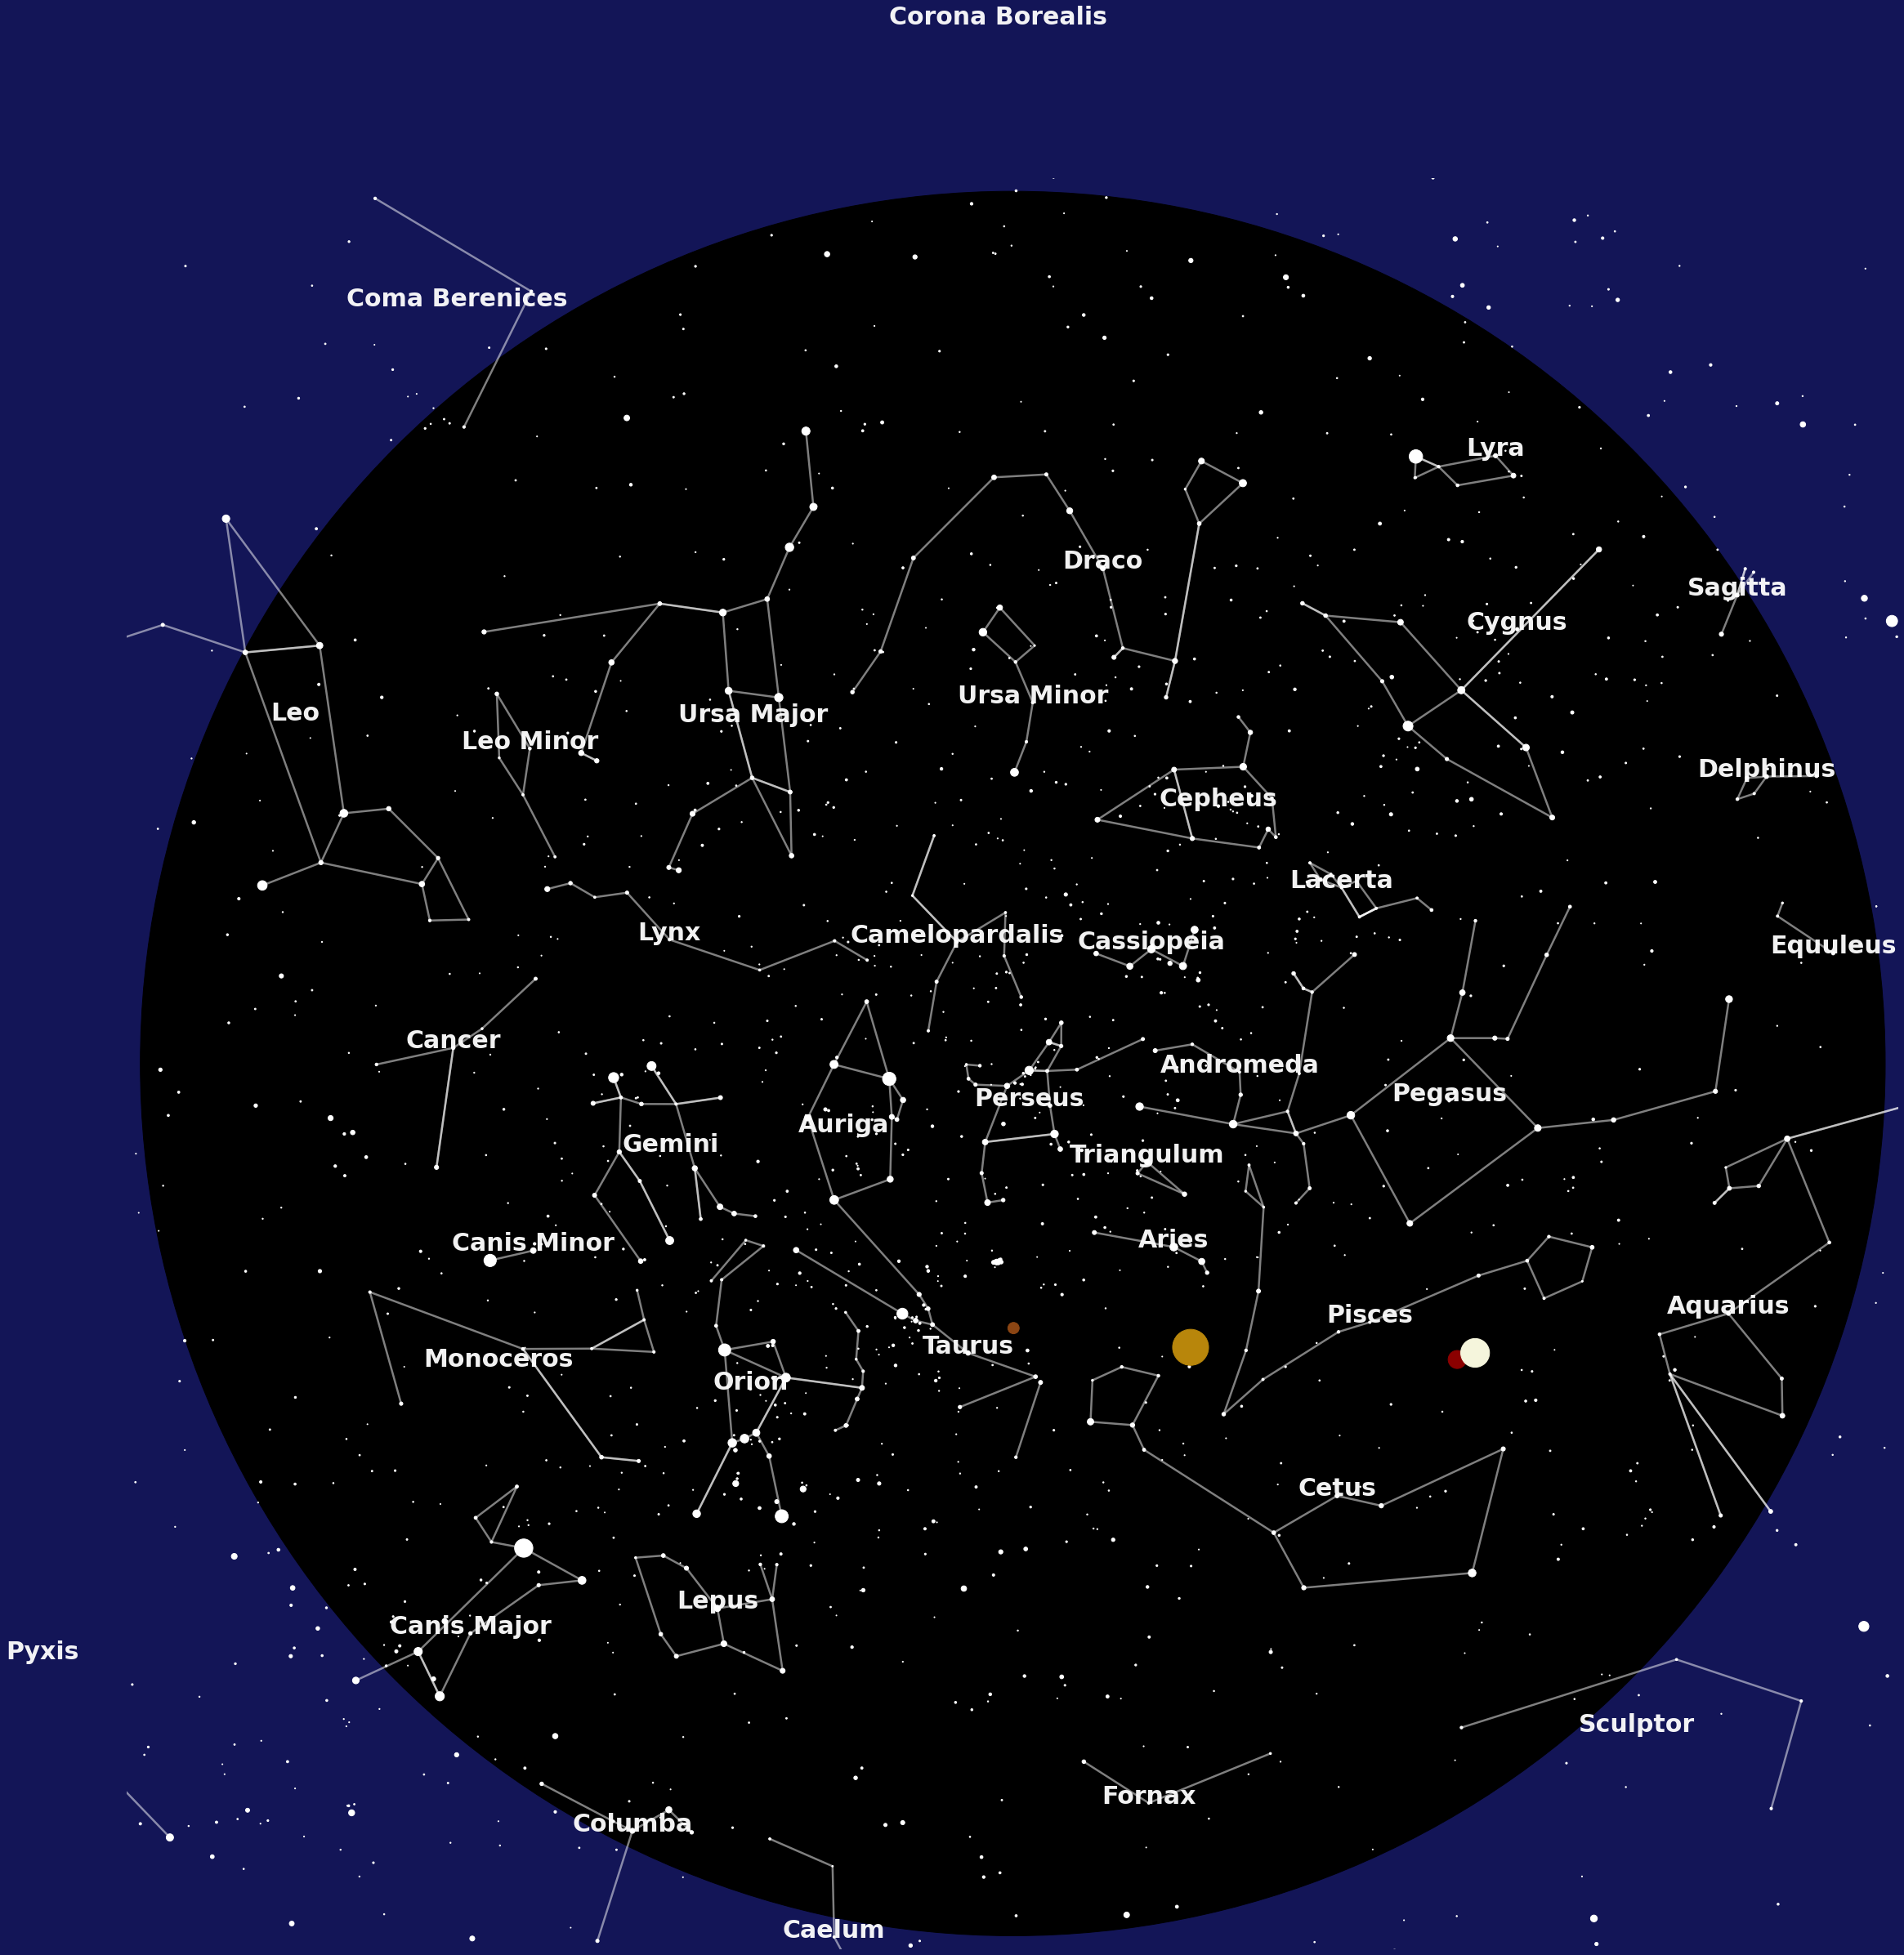

In [1]:
# code to move name if over limit.
# move planet label if overlap

import numpy as np
from matplotlib import pyplot as plt
from matplotlib.collections import LineCollection, PolyCollection
%matplotlib inline
import pandas as Pd
import csv
from skyfield.api import Star, load, wgs84, N, S, W, E
from skyfield.data import hipparcos, mpc, stellarium
from skyfield.projections import build_stereographic_projection
from datetime import datetime
from pytz import timezone
from PIL import Image, ImageOps, ImageFont, ImageDraw
import io 
import os
import math
from skyfield.magnitudelib import planetary_magnitude
from matplotlib import font_manager

###
'''Changable params'''
###
# Occasion, for file reference
occasion = 'Birthday'
#Date/time
ye = 2022
mo = 6
da = 1
ho = 12
mi = 0
se = 0
#Min star size magnitude, larger number is smaller star. i.e. setting to 3 will filter more stars than 5.
limiting_magnitude = 5.5
#Location that the sky is above. Takes decimal Lat/Long. I have set some pre figured out locations up in a dict.
lat = 51.548053
north_south = N
long = 0.014573
west_east = W
quick_locations = {'Isfield':[50.935391*N,0.066639*E],'Uckfield':[50.975185*N,0.103074*E],'Greenwich':[51.476275*N,0.017379*W],
                   'Fordingbridge':[50.928351*N,1.792717*W],'Leyton':[51.557190*N,0.014148*W],'Capetown':[33.926145*S,18.420075*E]}
quick_place = 'Isfield'
# Add text. Leave blabk to not include the line.
line_1 = u'Location: Stratford'
line_2 = u'Latitude: 51°33\'N, Longitude: 0°01\'W'
line_3 = u'Time: 1st June 2022, 00:00'
#Choose colours of different elements. In order these are; the outer bg colour, the colour of the plotted data/lines/labels,
#The colour of the dial, the colour of the accompanying text, the colour of the inner disc on which the stars/data show.
#Currently colours available are:black, white, gold, red, blue, darkteal, grey. More can be added to colour_dict below.
background_colour = 'blue'
feature_colour = 'white'
dial_colour = 'white'
text_colour = 'white'
inner_colour = 'black'
# Choose type of design.Can have just the stars plotted, stars with constellation lines, stars lines and labels. 
#Respectively these are denoted by: stars, starsandlines,all.
data_type = 'all'
# Location of text. Options are: above,below,none.
text_loc = 'below'
# Include Planets. True or False
include_planets = True
# Planets key or planets labels or none. Options are: label,key,none
key_label_none = 'key'


#
# Add text lines to a list.
line_list = []
for line in [line_1,line_2,line_3]:
    if line:
        line_list.append(line)

# Set path to save images.
parent = '/Users/hazze/Documents/Python Scripts/StarMap/CreatedMaps'
path_to_save = os.path.join(parent, occasion)
if not os.path.exists(path_to_save):
    os.makedirs(path_to_save)

# Set the time of the map
GMT = timezone('Europe/London')
ts = load.timescale()
t = ts.from_datetime(GMT.localize(datetime(ye, mo, da, ho, mi, se)))

# Set the location of origin. Get postion of map, alt 90 is looking straight up, degree 0 is north, degree 180 is south.
if quick_place in quick_locations.keys():
    location = wgs84.latlon(quick_locations[quick_place][0], quick_locations[quick_place][1], elevation_m=0)
else:
    location = wgs84.latlon(lat*north_south, long*west_east, elevation_m=0)
degrees = 0.0
position = location.at(t).from_altaz(alt_degrees=90, az_degrees=degrees)

# An ephemeris from the JPL provides earth position. Set up dictionary for planet magnitudes and their positions later.
planets = ['mercury','venus','mars','jupiter','saturn','uranus','neptune']
ap_colours = ['saddlebrown','darkgoldenrod','darkred','beige','tan','powderblue','mediumblue']
eph = load('de421.bsp')
earth = eph['earth']
planet_df = Pd.DataFrame(ap_colours,index=planets,columns=['colours'])


# Load Star catalogue
with load.open(hipparcos.URL) as f:
    stardata = hipparcos.load_dataframe(f)

#Constellations and the star to use for name text location
with open(r'.\Data\consmain.csv', mode='r') as infile:
    reader = csv.reader(infile)
    consmain = {rows[0]:rows[1] for rows in reader}

# Load constellation outlines and star name data
url = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/western_SnT/constellationship.fab')
with load.open(url) as f:
    consdata = stellarium.parse_constellations(f)

url2 = ('https://raw.githubusercontent.com/Stellarium/stellarium/master'
       '/skycultures/western_SnT/star_names.fab')
with load.open(url2) as f2:
    star_names = stellarium.parse_star_names(f2)

#Function to generate constellation lines.
def generate_constellation_lines(data, polygon=False):
    edges = [edge for name, edges in data for edge in edges]
    edges_star1 = [star1 for star1, star2 in edges]
    edges_star2 = [star2 for star1, star2 in edges]
    xy1 = stardata[['x', 'y']].loc[edges_star1].values
    xy2 = stardata[['x', 'y']].loc[edges_star2].values

    if polygon:
        return [xy1]
    else:

        # constellation lines begin at the x,y of one star and end at x,y of another.
        # rollaxis the resulting coordinate array into the shape that matplotlib expects.
        return np.rollaxis(np.array([xy1, xy2]), 1)

# Function to return centre of triangle, for labelling purposes later.    
def centroid(coordinate_list):
    x1 = coordinate_list[0]
    x2 = coordinate_list[1]
    x3 = coordinate_list[2]
    X = (x1[0]+x2[0]+x3[0])/3
    Y = (x1[1]+x2[1]+x3[1])/3
    return [X,Y]

#Function to load plot as img.
def fig2img(fig):
    buf = io.BytesIO()
    fig.savefig(buf)
    buf.seek(0)
    img = Image.open(buf)
    return img
    
# Center the chart on the given postion
projection = build_stereographic_projection(position)
field_of_view_degrees = 180.0

# Projection has been constructed,X,Y can be calculated for each star.
star_positions = earth.at(t).observe(Star.from_dataframe(stardata))
stardata['x'], stardata['y'] = projection(star_positions)

# Calculate x,y for each planet.
planet_xy = []
planet_magnitude = []
for planet in planets:
    planet_name = planet + ' barycenter'
    planet_data = earth.at(t).observe(eph[planet_name])
    planet_magnitude.append(float(planetary_magnitude(planet_data)))
    
    planet_xy.append(projection(planet_data))
planet_df = planet_df.join(Pd.DataFrame(planet_xy,columns=['X','Y'],index=planets))
planet_df = planet_df.join(Pd.DataFrame(planet_magnitude,columns=['magnitude'],index=planets))


# Filter df by star magnitude.
# Filter df by stars inside imposed horizon limit, circle radius 1 from origin.
# Using 1.2 as radius here to capture part constellations at the edge.
# Set marker size to be based on star magnitude.
bright_stars = stardata[stardata['magnitude'] <= limiting_magnitude]
bright_stars = bright_stars[(bright_stars['x']**2 + bright_stars['y']**2)**0.5 <= 1.4]
magnitude = bright_stars['magnitude']
marker_size = (1 + limiting_magnitude - magnitude) ** 3

# Filter planet df by magnitude.
# Filter df by planets inside imposed horizon limit, circle radius 1 from origin.
# Using 1 as radius here as no need to capture planets outside edge.
# Set marker size based on planet magnitude.
# get list of limited planet names and the number.
planets_limited = planet_df[planet_df['magnitude'] <= limiting_magnitude]
planets_limited = planets_limited[(planets_limited['X']**2 + planets_limited['Y']**2)**0.5 <= 1]
pl_mag = planets_limited['magnitude']
planet_marker = (3 + limiting_magnitude - pl_mag) ** 3
limited_names = planets_limited.index.tolist()
planet_count = len(limited_names)


# Dictionary used for converting constellation names with spaces in them.
spaces_dict = {'LeoMinor':'Leo Minor','CanisMajor':'Canis Major','ComaBerenices':'Coma Berenices',
               'CoronaBorealis':'Corona Borealis','UrsaMinor':'Ursa Minor', 'UrsaMajor':'Ursa Major',
               'TriangulumAu':'TriangulumA', 'PiscisAustrinus':'Piscis Au','CanisMinor':'Canis Minor'}

# Dictionary for colour codes.
colour_dict = {'black': '#000000','white':'#ffffff','blue':'#131557','darkteal':'#144254','red':'#6b292d',
               'grey':'#303030','gold':'#FFD700'}

# Dictionary for various element positions, based on text location. If including key but no text, there are new none values
# In order: anchorx, anchory, mask circle height param, dial mask y coord,
# line1/2/3 y coordinates,mask_key rect y, mask_key overlay x,mask_key overlay y. 
positions_dict = {'above':[0.5,0.3,0.56,206,-3036,-2956,-2876,1980,450,-1460],
                  'below':[0.5,0.7,0.44,-206,-630,-550,-470,1580,450,1360],
                  'none':[0.5,0.5,0.5,0,0,0,0,1580,-150,1360]}
if text_loc == 'none' and key_label_none == 'key' and include_planets:
    positions_dict = {'above':[0.5,0.3,0.56,206,-3036,-2956,-2876,1980,450,-1460],
                  'below':[0.5,0.7,0.44,-206,-630,-550,-470,1580,450,1360],
                  'none':[0.5,0.7,0.44,-206,-630,-550,-470,1580,-75,1360]}

# Dictionary of triangulation star hips for better labelling.
triangulation_dict = {'Libra':[72622,74785,76333],'Hercules':[83207,84345,80816],'Coma Berenices':[60742,64394,64241],
                     'Auriga':[25428,28380,24608],'Gemini':[32246,34088,34693],'Leo':[54872,54879,49583],
                     'Perseus':[18532,14328,14576],'Ursa Major':[54061,48319,53910],'Vela':[42913,44816,52727],
                     'Tucana':[110130,114996,1599],'Hydrus':[9236,2021,17678],'Antlia':[53502,46515,51172],
                     'Octans':[70638,112405,107089],'Centaurus':[68002,61932,66657],'Indus':[101772,108431,103227],
                     'Corvus':[61359,59316,60965],'Ara':[85727,83081,85792],'Ophiuchus':[86032,79593,84012],
                     'Grus':[109268,112122,111043],'Sculptor':[4577,116231,117452],'Capricornus':[102978,107556,100345],
                     'Monoceros':[39863,30867,34769]}



# Create the figures
fig, ax = plt.subplots(figsize=[34, 48])
fig.set_facecolor(colour_dict[background_colour])
plt.subplots_adjust(left=0.1)

#Remove all extra graph features. Set limit for the graph. Set aspect to position graph. Tight layout to fill space.
angle = np.pi - field_of_view_degrees / 360.0 * np.pi
limit = np.sin(angle) / (1.0 - np.cos(angle))
ax.set_xlim(-limit-0.06, limit+0.06)
ax.set_ylim(-limit-0.06, limit+0.06)
ax.xaxis.set_visible(False)
ax.yaxis.set_visible(False)
ax.axis('off')
ax.grid(False)
plt.tight_layout(pad=14)
ax.set_aspect(1.0,anchor=(positions_dict[text_loc][0],positions_dict[text_loc][1]))

# Creates key image items for planets, even if this isn't to be used.
# Sets the xy locations for planets used in key, these are vertically aligned. Uses scatter to create images of planets.
# Creates a string with the planet names on different lines, adds this as text next to the planets.
# Create image based off of the current fig.
key_x = [0]*planet_count
key_y = [i*0.08 for i in range(len(key_x))]
key = ax.scatter(key_x,key_y,
           s=planet_marker, color=planets_limited['colours'])
planet_caps = [x.capitalize() for x in limited_names]
planet_caps.reverse()
key_string = '\n'.join(planet_caps)
font_prop = font_manager.FontProperties(fname=r'.\Fonts\EbGaramond08Regular-2mWe.ttf')
key_text = ax.text(0.05,-0.013, key_string, c=colour_dict[feature_colour],
                   weight='bold',ma='left', linespacing=2.5, font_properties=font_prop, fontsize=42)
key_image = fig2img(plt)

# Set inner background colour
circle2 = plt.Circle((0, 0), 1.044, color=colour_dict[inner_colour],zorder=-10,fill=True)
ax.add_patch(circle2)
    
# Create background image based off of the current fig. Solid bg colour. Get figure size.
# Get the size of the axes to use for mask. Size is slightly too big, so need to remove 100px in each direction.
# Removes the key image items so they don't show on the final image.
bg_image = fig2img(plt)
w,h = bg_image.size
bbox = ax.get_window_extent().transformed(fig.dpi_scale_trans.inverted())
width, height = math.ceil((bbox.width)*fig.dpi)-100, math.ceil((bbox.height)*fig.dpi)-100
key.set_visible(False)
key_text.set_visible(False)
# bg_image.show()

# Create a mask image that is just the circle where the data is plotted in. Circle coords depend on the text location.
# Invert this image so the mask is just the area outside the plot.
mask_outer = Image.new("L", bg_image.size, 0)
draw = ImageDraw.Draw(mask_outer)
draw.ellipse(((w-width)/2, (h*positions_dict[text_loc][2]-height/2),
              (w+width)/2, (h*positions_dict[text_loc][2]+height/2)), fill=255)
mask_outer = ImageOps.invert(mask_outer)

# Create a mask that is just a rectangle where the key is on the background image.
mask_key = Image.new("L", bg_image.size, 0)
draw1 = ImageDraw.Draw(mask_key)
rect_w = 300
rect_h = planet_count*85
draw1.rectangle((1450-rect_w,positions_dict[text_loc][7]-rect_h,1450,positions_dict[text_loc][7]), fill=255)

# Draw the stars and write figure to image variable. If including planets, do the same for these.
ax.scatter(bright_stars['x'], bright_stars['y'],
           s=marker_size, color=colour_dict[feature_colour])
stars_image = fig2img(plt)
if include_planets:
    ax.scatter(planets_limited['X'], planets_limited['Y'],
           s=planet_marker, color=planets_limited['colours'])
    stars_image = fig2img(plt)

# Draw the constellation lines. Only shows constellations with every star in df (not filtered by magnitude or horizon).
# Write figure to image.
newconsdata = []
for i in consdata:
    name = i[0]
    stars = i[1]
    all_stars = []
    in_limit = True
    for pair in stars:      
        if pair[0] not in all_stars:
            all_stars.append(pair[0])
        if pair[1] not in all_stars:
            all_stars.append(pair[1])
    for star in all_stars:
        if star not in bright_stars.index:
            in_limit = False
    if in_limit:
        newconsdata.append(i)

cons_lines = generate_constellation_lines(newconsdata)
constellations = LineCollection(cons_lines,
                                colors=colour_dict[feature_colour], linewidths=2.5, zorder=-1, alpha=0.5)
ax.add_collection(constellations)
starsandlines_image = fig2img(plt)

# # Adds star names (testing)
# for item in star_names:
#     hip = item[0]
#     name = item[1]

#     if hip in bright_stars.index:
#         bsrow = bright_stars.loc[[hip]]
#         ax.text(bsrow['x']+ 0.004,bsrow['y']- 0.004, str(name),c='white',fontsize=9, 
#                 weight='bold', ha='left', va='top',zorder=1, alpha=0.5)
# # Adds hip to each star (testing)
# for i, s in bright_stars.iterrows():
#     ax.text(s['x'],s['y'], str(i),c='white',fontsize=8, weight='bold', alpha=0.6, zorder=1)

# Adds planet names if this is selected
if key_label_none == 'label':
    for planet in limited_names:
        bsrow = planet_df.loc[[planet]]
        ax.text(bsrow['X']+ 0.01,bsrow['Y']- 0.004, str(planet.capitalize()),c='white',
                fontsize=35, weight='bold', ha='left', va='top',zorder=1, alpha=0.95)

# Adds constellation names. Will use a custom location if star is in triangulation_dict. Again write fig to image.
for row in newconsdata:
    name = row[0]
    hip = row[1][0][0]
    consmain_star = int(consmain[name])
    if name in spaces_dict:
            name = spaces_dict[name]
    
    # If in dictionary, uses 3 pre selected stars to get a center point for label. Else just uses star from consmain.
    if name in triangulation_dict.keys():
        tstars = triangulation_dict[name]
        xy_coordinates = []
        for tstar in tstars:
            xy_temp = []
            bsrow = bright_stars.loc[[tstar]]
            xy_temp = [float(bsrow['x']),float(bsrow['y'])]
            xy_coordinates.append(xy_temp)
        label_xy = centroid(xy_coordinates)
        ax.text(label_xy[0],label_xy[1], str(name),c=colour_dict[feature_colour],
                fontsize=30, weight='bold', ha='center',alpha=0.95,zorder=1)
    elif consmain_star in bright_stars.index:
        bsrow = bright_stars.loc[[consmain_star]]
        if name != 'Horologium':
            ax.text(bsrow['x'],bsrow['y'], str(name),c=colour_dict[feature_colour],
                    fontsize=30, weight='bold', ha='center',alpha=0.95,zorder=1)
map_image = fig2img(plt)

# Create a solid colour image to use as dial overlay with dial mask. opens overlay dial image.
solid_image = Image.new('RGB', (w, h), (colour_dict[dial_colour]))
dial_image = Image.open(r".\Overlays\dialmid.png")

# overlay image based on selection, i.e stars only, overlay dial with position based text location, write to final image.
if data_type == 'stars':
    stars_image.paste(bg_image, (0,0), mask = mask_outer)
    stars_image.paste(solid_image, (0,positions_dict[text_loc][3]), mask = dial_image)
    final_image = stars_image
elif data_type == 'starsandlines':
    starsandlines_image.paste(bg_image, (0,0), mask = mask_outer)
    starsandlines_image.paste(solid_image, (0,positions_dict[text_loc][3]), mask = dial_image)
    final_image = starsandlines_image
else:
    map_image.paste(bg_image, (0,0), mask = mask_outer)
    map_image.paste(solid_image, (0,positions_dict[text_loc][3]), mask = dial_image)
    final_image = map_image

# If including planets and a key, overlays created key image at specified position.    
if key_label_none == 'key' and include_planets:
    final_image.paste(key_image, (positions_dict[text_loc][8],positions_dict[text_loc][9]+rect_h//2), mask = mask_key)    

    # Add text to image. gets font type and size. Centers text based on text width.
    # for loop positions text based on number of lines and text above or below. Uses the position dict for locations. 
    draw = ImageDraw.Draw(final_image)
    myFont = ImageFont.truetype(r'.\Fonts\EbGaramond08Regular-2mWe.ttf', 55)
    for i,line in enumerate(line_list):
        text_w, text_h = draw.textsize(line,myFont)
        if text_loc == 'none':
            break;
        elif len(line_list) == 1:
            draw.text((450, h+positions_dict[text_loc][5]), line,font=myFont, fill=(colour_dict[text_colour]))
        else:
            draw.text((450, h+positions_dict[text_loc][i+4]), line,font=myFont, fill=(colour_dict[text_colour]))
# Otherwise centers text at specified location
else:
    draw = ImageDraw.Draw(final_image)
    myFont = ImageFont.truetype(r'.\Fonts\EbGaramond08Regular-2mWe.ttf', 55)
    for i,line in enumerate(line_list):
        text_w, text_h = draw.textsize(line,myFont)
        if text_loc == 'none':
            break;
        elif len(line_list) == 1:
            draw.text(((w -text_w)// 2, h+positions_dict[text_loc][5]), line,font=myFont, fill=(colour_dict[text_colour]))
        else:
            draw.text(((w -text_w)// 2, h+positions_dict[text_loc][i+4]), line,font=myFont, fill=(colour_dict[text_colour]))

# Save image. Choose to show it. Close memory.
# final_image.save(path_to_save+'/final.png')
final_image.show()
io.BytesIO().close()
